# Longformer model using last 512 tokens of text



In [ ]:
!pip install transformers

In [ ]:
#!pip install torch-lr-finder

In [ ]:
#!pip install pytorch-model-summary

import numpy as np
import pandas as pd
import warnings
import time
import datetime
import re
import random

from sklearn.metrics import precision_recall_fscore_support

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# PyTorch Imports
import torch # a tensor library
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#Huggingface Transformers
import transformers
from transformers import get_linear_schedule_with_warmup

from transformers import LongformerModel, LongformerTokenizer, LongformerConfig
from transformers import LongformerForSequenceClassification, AdamW

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Model Set Up
Set up the model and the configuration we need

- max_len - how many tokens will be used from the document.
- batch_size - reduce if memory issues. paper reccomends 16-32
- num epochs

- tokenizer - this should be a pretrined tokenizer, e.g. distilBert. 
- model - make sure it uses the same tokenizer for generating the weights

#### input files
- train.csv: heading removed, dates and URL replcaed, un-cased, sentence breaks and punctuation included  
- train_lcase.csv: heading removed, dates and URL replcaed, lower cased, sentence breaks and punctuation removed
  

In [ ]:
train_file = "train.csv"
test_file = "test.csv"


max_len = 512
batch_size = 8
num_epochs = 5
lr = 3e-5
use_global_mask = False

config = LongformerConfig.from_pretrained('allenai/longformer-base-4096',
    #attention_mode = 'sliding_chunks',
    num_labels=2,
    dropout = 0.2,
    attention_dropout = 0.2,
    output_attentions = False,
    output_hidden_states = False
    )


tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', config = config)
                                                       

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

## Helper Functions

In [ ]:
# Function to get data
def get_data(fname):
    df = pd.read_csv(fname)
    df = df[['cleaned_contents', 'Discrimination_Label']]
    df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
    df.reset_index(inplace=True, drop=True)
    return df

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Function to format elapsed time 
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Function to tokenize data and return tensors for input ids, attention mask and labels
def tokenize_plus(df, reverse=False):

    if reverse:
      sentences = df['txet'].values
    else:
      sentences = df['text'].values


    labels = df['label'].values

    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                     
                            add_special_tokens = True, 
                            max_length = max_len,    
                            truncation = True,
                            pad_to_max_length = True,
                            return_attention_mask = True, 
                            return_tensors = 'pt'    
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [ ]:
# Function to reverse a string
def rev_sentence(sentence): 
  
    # first split the string into words 
    words = sentence.split(' ')  
  
    # then reverse the split string list and join using space 
    reverse_sentence = ' '.join(reversed(words))  
  
    # finally return the joined string 
    return reverse_sentence   

# Fine Tuning and training

In [ ]:
df = get_data(train_file)
df.head()

,text,label
0,SENTENCE\n\n\t1.\tYou are charged as follows:\...,0
1,"SENTENCE\n\n\t1.\tJOSEFA KOTOBALAVU, you were ...",1
2,SENTENCE\n\n1. The Director of Public Prosecut...,1
3,"SENTENCE\n\n\t1.\tMOHOMMED NABI UD- DEAN, you ...",1
4,JUDGMENT OF THE COURT\n\nBackground\n\n[1] The...,0


In [ ]:
df['txet'] =df['text'].apply(lambda x: rev_sentence(x))

In [ ]:
# Get tokenized labels
input_ids, attention_masks, labels = tokenize_plus(df, reverse=True)

In [ ]:
input_ids_np =  input_ids.numpy()
#input_ids_np

In [ ]:
df[df["text"].str.find('breadwinner')>0].head()

,text,label,txet
2,SENTENCE\n\n1. The Director of Public Prosecut...,1,<URL>\n\n\n\n\n Feedback\nURL: | Policy Privac...
54,JUDGMENT\n \n• The appellant was charged wit...,1,\n\n \n <URL>\n URL: Feedback\n | Policy Pr...
77,SENTENCE\n\nRavneel Ravikash Lal you have been...,1,<URL>\n\n\n\n\n Feedback\nURL: | Policy Privac...
85,JUDGMENT\n\nBackground\n\nThe appellant pleade...,1,<URL>\n\n\n\n\n Feedback\nURL: | Policy Privac...
97,JUDGMENT\n[DOMESTIC VIOLENCE]\n\n1. On the 9th...,0,<URL>\n\n\n\n\n Feedback\nURL: | Policy Privac...


In [ ]:
len(tokenizer.convert_ids_to_tokens(input_ids_np[2]))

512

In [ ]:
#np.set_printoptions(threshold=np.inf)
#print(input_ids_np[2])




In [ ]:
global_attention_mask = np.where(input_ids != 0, 0, 0)

In [ ]:
# What GPU are we using?
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
df['txet'][2]

'<URL>\n\n\n\n\n Feedback\nURL: | Policy Privacy | Disclaimers | Policy Copyright Accused\n\n\nPacLII: for Commission Aid Legal the of Office State\n- for Prosecutions Public of Director the of Office - Thurairaja\nJUDGE\n\nSolicitors: \n\nS. imprisonment. years 16 is sentence Your concurrently. run to sentences both your order I guilty, pleaded have you Since appeal.\n\n33. to days 30 you.\n\n32. to punishment deterrent a impose I mind, in children other your \n\nHaving mercy. no shown and condemned be should daughter, own his against crime of sort this commits father a of position a as such authority, in person a When Exploitation. and Abuse Sexual from children protect to endevours all making is world entire the and Government that mindful am I years.\n\n31. 16 is sentence your Now years. 4 reduce I circumstances, mitigating above all 2010.\n\nConsidering March since remand in were You Police.\n\ne) the with co-operated You remorseful.\n\nd) are You family.\n\nc) your of breadwinner

In [ ]:
# Print the original sentence.
#print(' Original: ', df['text'][0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df['txet'][2]))

# Print the sentence mapped to token ids.
#print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Tokenized:  ['<', 'URL', '>', 'ĊĊ', 'ĊĊ', 'Ċ', 'ĠFeedback', 'Ċ', 'URL', ':', 'Ġ|', 'ĠPolicy', 'ĠPrivacy', 'Ġ|', 'ĠDis', 'claim', 'ers', 'Ġ|', 'ĠPolicy', 'ĠCopyright', 'ĠAcc', 'used', 'ĊĊ', 'Ċ', 'Pac', 'L', 'II', ':', 'Ġfor', 'ĠCommission', 'ĠAid', 'ĠLegal', 'Ġthe', 'Ġof', 'ĠOffice', 'ĠState', 'Ċ', '-', 'Ġfor', 'ĠPro', 'sec', 'utions', 'ĠPublic', 'Ġof', 'ĠDirector', 'Ġthe', 'Ġof', 'ĠOffice', 'Ġ-', 'ĠThur', 'air', 'aja', 'Ċ', 'J', 'UD', 'GE', 'Ċ', 'Ċ', 'Sol', 'icit', 'ors', ':', 'Ġ', 'Ċ', 'Ċ', 'S', '.', 'Ġimprisonment', '.', 'Ġyears', 'Ġ16', 'Ġis', 'Ġsentence', 'ĠYour', 'Ġconcurrently', '.', 'Ġrun', 'Ġto', 'Ġsentences', 'Ġboth', 'Ġyour', 'Ġorder', 'ĠI', 'Ġguilty', ',', 'Ġpleaded', 'Ġhave', 'Ġyou', 'ĠSince', 'Ġappeal', '.', 'Ċ', 'Ċ', '33', '.', 'Ġto', 'Ġdays', 'Ġ30', 'Ġyou', '.', 'Ċ', 'Ċ', '32', '.', 'Ġto', 'Ġpunishment', 'Ġdeterrent', 'Ġa', 'Ġimpose', 'ĠI', 'Ġmind', ',', 'Ġin', 'Ġchildren', 'Ġother', 'Ġyour', 'Ġ', 'Ċ', 'Ċ', 'Having', 'Ġmercy', '.', 'Ġno', 'Ġshown', 'Ġand', 'Ġcondemned', 

In [ ]:
# get the ids for bread winner in case we want to add global attention
tokenizer.convert_tokens_to_ids(['Ġbread', 'winner'])

[8084, 20547]

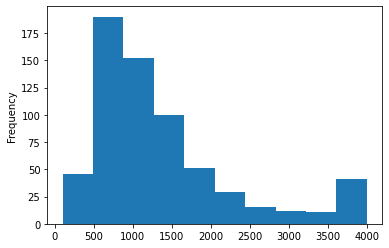

In [ ]:
df['text'].apply(lambda x: len(x.split()) if len(x.split())<4000 else 4000).plot(kind='hist')

In [ ]:
df['len_txt'] =df['text'].apply(lambda x: len(x.split()))
df.describe()

,label,len_txt
count,647.000000,647.000000
mean,0.571870,1516.514683
std,0.495191,1698.831551
min,0.000000,99.000000
25%,0.000000,750.500000
50%,1.000000,1123.000000
75%,1.000000,1635.500000
max,1.000000,28652.000000


In [ ]:
len(df[df['len_txt'] > 512]) 

598

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
# check size of embeddings
print(len(input_ids))
print(len(input_ids[0]))

647
512


In [ ]:
# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  582 training samples
   65 validation samples


In [ ]:
# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
# Tell pytorch to run this model on the GPU.
model.cuda()

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 275 different named parameters.

==== Embedding Layer ====

longformer.embeddings.word_embeddings.weight            (50265, 768)
longformer.embeddings.position_embeddings.weight         (4098, 768)
longformer.embeddings.token_type_embeddings.weight          (1, 768)
longformer.embeddings.LayerNorm.weight                        (768,)
longformer.embeddings.LayerNorm.bias                          (768,)

==== First Transformer ====

longformer.encoder.layer.0.attention.self.query.weight    (768, 768)
longformer.encoder.layer.0.attention.self.query.bias          (768,)
longformer.encoder.layer.0.attention.self.key.weight      (768, 768)
longformer.encoder.layer.0.attention.self.key.bias            (768,)
longformer.encoder.layer.0.attention.self.value.weight    (768, 768)
longformer.encoder.layer.0.attention.self.value.bias          (768,)
longformer.encoder.layer.0.attention.self.query_global.weight   (768, 768)
longformer.encoder.layer.0.attention.self.query_global.bi

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = num_epochs

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs
warmup_steps = total_steps * 0.1

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Train the model
device = torch.device("cuda")
training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 16 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device) # input ids
        b_input_mask = batch[1].to(device) # attention masks
        b_labels = batch[2].to(device) # labels

        # Clear previously calculated gradients before performing backward pass. 
        model.zero_grad()        

        # Forward pass
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item() # Accumulate the training loss over all of the batches 

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    16  of     73.    Elapsed: 0:00:46.
  Batch    32  of     73.    Elapsed: 0:01:31.
  Batch    48  of     73.    Elapsed: 0:02:17.
  Batch    64  of     73.    Elapsed: 0:03:02.

  Average training loss: 0.70
  Training epcoh took: 0:03:27

Running Validation...
  Accuracy: 0.57
  Validation Loss: 0.68
  Validation took: 0:00:06

======== Epoch 2 / 5 ========
Training...
  Batch    16  of     73.    Elapsed: 0:00:45.
  Batch    32  of     73.    Elapsed: 0:01:31.
  Batch    48  of     73.    Elapsed: 0:02:16.
  Batch    64  of     73.    Elapsed: 0:03:02.

  Average training loss: 0.69
  Training epcoh took: 0:03:27

Running Validation...
  Accuracy: 0.57
  Validation Loss: 0.68
  Validation took: 0:00:06

======== Epoch 3 / 5 ========
Training...
  Batch    16  of     73.    Elapsed: 0:00:45.
  Batch    32  of     73.    Elapsed: 0:01:31.
  Batch    48  of     73.    Elapsed: 0:02:16.
  Batch    64  of     73.    Elapsed: 0:03:02.



In [ ]:
# Display Results
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.70,0.68,0.57,0:03:27,0:00:06
2,0.69,0.68,0.57,0:03:27,0:00:06
3,0.67,0.59,0.69,0:03:27,0:00:06
4,0.64,0.55,0.74,0:03:27,0:00:06
5,0.61,0.54,0.71,0:03:27,0:00:06


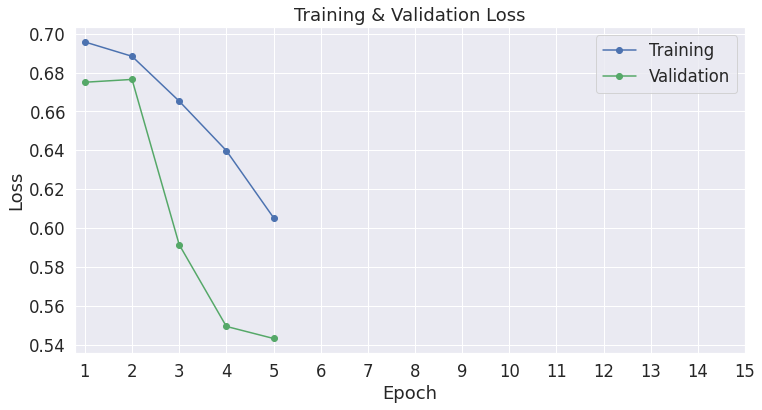

In [ ]:
# Plot the learning curve.

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15])

plt.show()

# TEST THE MODEL

In [ ]:
# Holdout
df = get_data(test_file)
df.head()

,text,label
0,SENTENCE\n\n[Name of the victim is suppressed....,1
1,JUDGMENT\n\nThis is an appeal against convicti...,1
2,"JUDGMENT\n\n1. On 13 May 2008, the Appellant, ...",1
3,JUDGMENT\n[1] On the 17th July 2012 in the Nas...,0
4,SENTENCE\n\nBackground \n\n1. The accused was ...,1


In [ ]:
# Get tokenized labels
if use_global_mask:
    input_ids, attention_masks, labels = tokenize_manual(df)
else:
    input_ids, attention_masks, labels = tokenize_plus(df)

In [ ]:
# create dataloader from input tensors, to help with memory usage
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 162 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 97 of 162 (59.88%)


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

scores = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='binary')

# Calculate the P,R,F1
print('Precision, Recall, F1, Support:', scores)

Precision, Recall, F1, Support: (0.6666666666666666, 0.8041237113402062, 0.7289719626168224, None)


In [ ]:
# get the bad predictions index
bad_preds = [idx for idx, elem in enumerate(flat_predictions) if elem != flat_true_labels[idx]] 
good_preds = [idx for idx, elem in enumerate(flat_predictions) if elem == flat_true_labels[idx]] 
print("number of good predictions:", len(good_preds))
print("number of bad predictions:", len(bad_preds))
print("accuracy", len(good_preds)/len(flat_predictions) )

number of good predictions: 104
number of bad predictions: 58
accuracy 0.6419753086419753


In [ ]:
print(flat_predictions)

[1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0
 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
